## Background

A well-established bank in Asia Pacific is looking to use data to better their nonperforming loan ratio.

Nonperforming loan ratio is the amount of nonperforming loans to the total amount of outstanding loans the bank holds.

## Problem statement

The bank wants to predict whether a loan will be payed back to the bank or not. At the moment, the bank if fully dependent on the credit risk rating and their past experience. However, the bank is unable to accurately predict whether a client is able to pay their loan back on a continuous month to month.

Using [Default of Credit Card Clients Dataset](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset), which contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005, the aim is to predict the risk of a client defaulting on a monthly installment and how much a client can pay in any given period.

## Executive Summary

We will use classifiers (Logistic Regression, Random Forest, XGBoost) to predict if a client is able to pay the installment in any given month and the risk of a client defaulting. We will then use regression (Linear Regression, Random Forest Regressor) to predict how much a client may be able to pay in any given period.

For exploratory data analysis, we found that:
- Although there are more females than males with credit cards, there is higher chance of defaulting if a client is a male.
- There is a general trend that the chances of defaulting increases as age increase.
- Although most credit cards holder are single, the highest percentage of defaults came from others, followed by married and single.
- Although most credit card holders have university and graduate school degree, the highest percentage of defaults came from clients with high school degree.
- As the credit limit increases, the percentage of clients defaulting decreases.
- Defaults seem to occur mostly when clients had a payment delay for more than 2 months.


For modeling:<br>
We are interested in both positive and negative classes. Hence, we will be using ROC AUC as our metric for classification, root mean squared error (RMSE) for regression so as to penalize large errors.

XGBoost proved to be the best classification model to separate defaulters and non defaulters. It attained the highest test ROC AUC score of 77% in separating the classes. Some of the top important features in determining if a client would default or not are repayment statuses and credit card limit amount.

Random forest regressor is the best model to predict how much a client can pay, with the lowest root mean squared error of 203 on test data.
The predictions and actual y values are close to one another, indicating a good prediction.

As the models performed relatively well on unseen data, banks can start to predict monthly if a client will default and serve their clients better to reduce their chances of defaulting.

## Contents
- [Import libraries](#Import-libraries)
- [Data dictionary](#Data-dictionary)
- [Data cleaning & EDA](#Data-cleaning-&-EDA)
- [Classification models](#Classification-models)
- [Regression models](#Regression-models)
- [Conclusions](#Conclusions)

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV, Lasso, Ridge, ElasticNet

#### Prevent scrolling of visualisation effect

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
# display max columns
pd.set_option('display.max_columns', None)

## Data dictionary

| Feature              | Type     | Description                                                                                        |
|:----------------------|:----------|:----------------------------------------------------------------------------------------------------|
| ID            | int      | ID of each client                                                                                  |
| LIMIT_BAL             | float      | Amount of given credit in NT dollars (includes individual and family/supplementary credit)                                                                           |
| SEX            | int      | Gender (1=male, 2=female)                                                                         |
| EDUCATION              | int      | (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)                                                                         |
| MARRIAGE                | int      | Marital status (1=married, 2=single, 3=others)                                                                  |
| AGE        | int      | Age in years                                              |
|PAY_0 | int      | Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above)                                                                                        |
| PAY_2                   | int | Repayment status in August, 2005 (scale same as above)                                                      |
| PAY_3         | int      | Repayment status in July, 2005 (scale same as above)                                                                       |
| PAY_4            | int | Repayment status in June, 2005 (scale same as above)                                                                    |
| PAY_5           | int      | Repayment status in May, 2005 (scale same as above) |
| PAY_6              | int      | Repayment status in April, 2005 (scale same as above)                                                      |
| BILL_AMT1               | float      | Amount of bill statement in September, 2005 (NT dollar)                                                      |
| BILL_AMT2              | float      |Amount of bill statement in August, 2005 (NT dollar)                                                     |
| BILL_AMT3              | float      | Amount of bill statement in July, 2005 (NT dollar)                                                      |
| BILL_AMT4               | float      | Amount of bill statement in June, 2005 (NT dollar)                                                      |
| BILL_AMT5               | float      | Amount of bill statement in May, 2005 (NT dollar)                                                      |
| BILL_AMT6               | float      | Amount of bill statement in April, 2005 (NT dollar)                                                      |
| PAY_AMT1               | float      | Amount of previous payment in September, 2005 (NT dollar)                                                      |
| PAY_AMT2               | float      | Amount of previous payment in August, 2005 (NT dollar)                                                      |
| PAY_AMT3               | float      | Amount of previous payment in July, 2005 (NT dollar)                                                      |
| PAY_AMT4               | float      | Amount of previous payment in June, 2005 (NT dollar)                                                      |
| PAY_AMT5              | float      | Amount of previous payment in May, 2005 (NT dollar)                                                      |
| PAY_AMT6              | float      | Amount of previous payment in April, 2005 (NT dollar)                                                      |
| default.payment.next.month              | int      | Default payment (1=yes, 0=no)                                                      |

## Data cleaning & EDA

In [5]:
# read in dataset
df = pd.read_csv('./datasets/UCI_Credit_Card.csv')

In [6]:
# display first 5 rows of dataset
df.head()

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1    20000.0    2          2         1   24      2      2     -1     -1   
1   2   120000.0    2          2         2   26     -1      2      0      0   
2   3    90000.0    2          2         2   34      0      0      0      0   
3   4    50000.0    2          2         1   37      0      0      0      0   
4   5    50000.0    1          2         1   57     -1      0     -1      0   

   PAY_5  PAY_6  BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  \
0     -2     -2     3913.0     3102.0      689.0        0.0        0.0   
1      0      2     2682.0     1725.0     2682.0     3272.0     3455.0   
2      0      0    29239.0    14027.0    13559.0    14331.0    14948.0   
3      0      0    46990.0    48233.0    49291.0    28314.0    28959.0   
4      0      0     8617.0     5670.0    35835.0    20940.0    19146.0   

   BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  \
0        0.0       0.0     689.0       0.0       0.0       0.0       0.0   
1     3261.0       0.0    1000.0    1000.0    1000.0       0.0    2000.0   
2    15549.0    1518.0    1500.0    1000.0    1000.0    1000.0    5000.0   
3    29547.0    2000.0    2019.0    1200.0    1100.0    1069.0    1000.0   
4    19131.0    2000.0   36681.0   10000.0    9000.0     689.0     679.0   

   default.payment.next.month  
0                           1  
1                           1  
2                           0  
3                           0  
4                           0

In [7]:
# pay 0 should be pay 1
df.rename(columns = {'PAY_0': 'PAY_1', 'default.payment.next.month': 'DEFAULT'}, inplace=True)

In [8]:
df.head()

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_1  PAY_2  PAY_3  PAY_4  \
0   1    20000.0    2          2         1   24      2      2     -1     -1   
1   2   120000.0    2          2         2   26     -1      2      0      0   
2   3    90000.0    2          2         2   34      0      0      0      0   
3   4    50000.0    2          2         1   37      0      0      0      0   
4   5    50000.0    1          2         1   57     -1      0     -1      0   

   PAY_5  PAY_6  BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  \
0     -2     -2     3913.0     3102.0      689.0        0.0        0.0   
1      0      2     2682.0     1725.0     2682.0     3272.0     3455.0   
2      0      0    29239.0    14027.0    13559.0    14331.0    14948.0   
3      0      0    46990.0    48233.0    49291.0    28314.0    28959.0   
4      0      0     8617.0     5670.0    35835.0    20940.0    19146.0   

   BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  \
0        0.0       0.0     689.0       0.0       0.0       0.0       0.0   
1     3261.0       0.0    1000.0    1000.0    1000.0       0.0    2000.0   
2    15549.0    1518.0    1500.0    1000.0    1000.0    1000.0    5000.0   
3    29547.0    2000.0    2019.0    1200.0    1100.0    1069.0    1000.0   
4    19131.0    2000.0   36681.0   10000.0    9000.0     689.0     679.0   

   DEFAULT  
0        1  
1        1  
2        0  
3        0  
4        0

In [9]:
df.duplicated().sum()

0

In [10]:
df.shape

(30000, 25)

In [11]:
# data types are all numeric
df.dtypes

ID             int64
LIMIT_BAL    float64
SEX            int64
EDUCATION      int64
MARRIAGE       int64
AGE            int64
PAY_1          int64
PAY_2          int64
PAY_3          int64
PAY_4          int64
PAY_5          int64
PAY_6          int64
BILL_AMT1    float64
BILL_AMT2    float64
BILL_AMT3    float64
BILL_AMT4    float64
BILL_AMT5    float64
BILL_AMT6    float64
PAY_AMT1     float64
PAY_AMT2     float64
PAY_AMT3     float64
PAY_AMT4     float64
PAY_AMT5     float64
PAY_AMT6     float64
DEFAULT        int64
dtype: object

In [12]:
# no null values
df.isnull().sum()

ID           0
LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_1        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
DEFAULT      0
dtype: int64

In [13]:
df.DEFAULT.value_counts(normalize=True)

0    0.7788
1    0.2212
Name: DEFAULT, dtype: float64

Unbalanced dataset, fewer defaulters for next month (0.22%).

### Gender

In [14]:
df.SEX.value_counts(normalize=True)

2    0.603733
1    0.396267
Name: SEX, dtype: float64

In [15]:
df.SEX = df.SEX.map({1: 'male', 2: 'female'})

In [16]:
gender = df.groupby(['SEX', 'DEFAULT']).size().reset_index()
gender['percentage'] = df.groupby(['SEX', 'DEFAULT']).size().groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).values
gender.columns = ['SEX', 'DEFAULT', 'Counts', 'Percentage']
px.bar(gender, x='SEX', y=['Counts'], color='DEFAULT', text=gender['Percentage'].apply(lambda x: '{0:1.2f}%'.format(x)))

Although there are more females than males with credit cards, there is higher chance of defaulting if a client is a male.

In [17]:
# convert to numeric value back
df.SEX = df.SEX.map({'male': 0, 'female': 1})

### Age

In [18]:
age = df.groupby(['AGE', 'DEFAULT']).size().reset_index()
age['percentage'] = df.groupby(['AGE', 'DEFAULT']).size().groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).values
age.columns = ['AGE', 'DEFAULT', 'Counts', 'Percentage']
def1 = age[age['DEFAULT']==1]

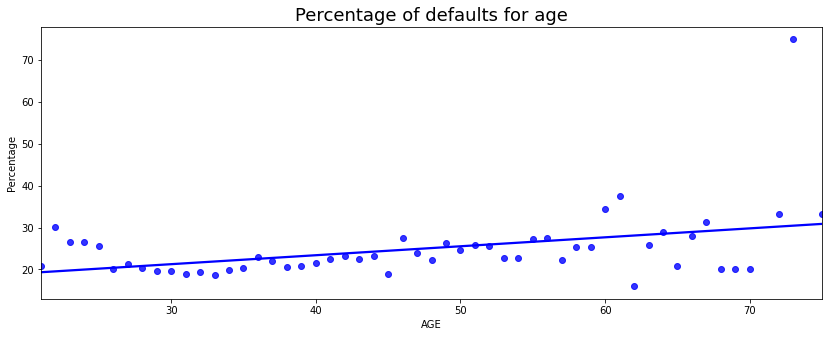

In [19]:
# plot for age (defaulted)
g = sns.regplot(x='AGE', y ='Percentage', data=def1, ci=None, color='blue')
g.figure.set_size_inches(14,5)
#g.set(ylim=(0, 40))
g.set_title('Percentage of defaults for age', size=18);

There is a slight increase in default as age increase. This may be because the older people get, the less money they have as they stop working.

In [20]:
def1[def1['Percentage']>70]

AGE  DEFAULT  Counts  Percentage
104   73        1       3        75.0

In [21]:
df[df.AGE==73]

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_1  PAY_2  PAY_3  \
387      388    80000.0    0          3         1   73     -1      0      0   
10699  10700   140000.0    0          2         1   73      0      0      0   
29163  29164   360000.0    1          3         1   73     -2     -2     -2   
29179  29180   500000.0    1          2         1   73     -2     -2     -2   

       PAY_4  PAY_5  PAY_6  BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  \
387        2      2      2    63144.0    65631.0    68875.0    70646.0   
10699      0      0      0   135206.0   135316.0   134943.0   135772.0   
29163     -2     -2     -2        0.0        0.0        0.0        0.0   
29179     -2     -2     -2        0.0     2826.0     2652.0     2835.0   

       BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  \
387      72870.0    75018.0    3500.0    4330.0    3500.0    3500.0    3500.0   
10699   138675.0   137197.0    5082.0    5008.0    5000.0    6016.0    5018.0   
29163        0.0        0.0       0.0       0.0       0.0       0.0       0.0   
29179     8896.0     3850.0    2826.0    2652.0    2835.0    8896.0    3850.0   

       PAY_AMT6  DEFAULT  
387      5100.0        1  
10699    5264.0        0  
29163       0.0        1  
29179     711.0        1

- For client ID 29164, we see that although she did not have any outstanding bill to pay, she was still predicted to default next month.
- For client 10700 and 29180, although they both paid duly, with the former having more bill amount left to pay than the latter, the former was predicted to not default while the latter was predicted to default.

We can't conclude how the prediction of default was made.

In [22]:
# min age is 21 and max age is 79
df['AGE'].describe()

count    30000.000000
mean        35.485500
std          9.217904
min         21.000000
25%         28.000000
50%         34.000000
75%         41.000000
max         79.000000
Name: AGE, dtype: float64

In [23]:
ranges = [20, 30, 40, 50, 60, 70, 80]
group_names = ['20-30', '30-40', '40-50', '50-60', '60-70', '70-80']
df['AGE_GROUP'] = pd.cut(df['AGE'], bins=ranges, labels=group_names)

In [62]:
# divide age into groups
age_group = df.groupby(['AGE_GROUP', 'DEFAULT']).size().reset_index()
age_group['percentage'] = df.groupby(['AGE_GROUP', 'DEFAULT']).size().groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).values
age_group.columns = ['AGE_GROUP', 'DEFAULT', 'Counts', 'Percentage']
px.bar(age_group, x='AGE_GROUP', y=['Counts'], color='DEFAULT', text=age_group['Percentage'].apply(lambda x: '{0:1.2f}%'.format(x)))

Most credit card holders are from age 20 to 30 years old. As age increases, the chances of defaulting increases, except range 30 to 40 years old. This might be because people will retire when they are old, resulting in fewer cash.

In [63]:
df.drop(columns=['AGE_GROUP'], axis=1, inplace=True)

### Marital status

In [64]:
df.MARRIAGE.value_counts(normalize=True)

2    0.532133
1    0.455300
3    0.010767
0    0.001800
Name: MARRIAGE, dtype: float64

In [219]:
# 0 and 3 are others
df.MARRIAGE = df.MARRIAGE.map({0: 'others', 1: 'married', 2: 'single', 3: 'others'})

In [220]:
df.MARRIAGE.value_counts(normalize=True)

single     0.532133
married    0.455300
others     0.012567
Name: MARRIAGE, dtype: float64

In [221]:
ms = df.groupby(['MARRIAGE', 'DEFAULT']).size().reset_index()
ms['percentage'] = df.groupby(['MARRIAGE', 'DEFAULT']).size().groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).values
ms.columns = ['MARRIAGE', 'DEFAULT', 'Counts', 'Percentage']
px.bar(ms, x='MARRIAGE', y=['Counts'], color='DEFAULT', text=ms['Percentage'].apply(lambda x: '{0:1.2f}%'.format(x)))

Although most credit cards holder are single, the highest percentage of defaults came from others, followed by married and single. This might be because after marriage, one will have a larger money expenditure.

In [222]:
# for regression
# df.MARRIAGE = df.MARRIAGE.map({'others': 0, 'single': 1, 'married': 2})

In [223]:
# one hot encoding
df = pd.get_dummies(df, columns = ['MARRIAGE'], drop_first=True)

### Education

In [224]:
df.EDUCATION.value_counts(normalize=True)

2    0.467667
1    0.352833
3    0.163900
5    0.009333
4    0.004100
6    0.001700
0    0.000467
Name: EDUCATION, dtype: float64

In [225]:
# convert 0,5 and 6 to 4 (others)
df.EDUCATION = df.EDUCATION.map({0: 'others', 1: 'grad sch', 2: 'uni', 3: 'high sch', 4: 'others', 5: 'others', 6: 'others'})

In [226]:
df.EDUCATION.value_counts(normalize=True)

uni         0.467667
grad sch    0.352833
high sch    0.163900
others      0.015600
Name: EDUCATION, dtype: float64

In [227]:
edu = df.groupby(['EDUCATION', 'DEFAULT']).size().reset_index()
edu['percentage'] = df.groupby(['EDUCATION', 'DEFAULT']).size().groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).values
edu.columns = ['EDUCATION', 'DEFAULT', 'Counts', 'Percentage']
px.bar(edu, x='EDUCATION', y=['Counts'], color='DEFAULT', text=edu['Percentage'].apply(lambda x: '{0:1.2f}%'.format(x)))

Although most credit card holders have university and graduate school degree, the highest percentage of defaults came from clients with high school degree. The higher the education level, the lower the probability of defaulting, with the exception from others. This might be because higher level of education may help one to earn a higher income.

In [228]:
# convert back to numeric value
df.EDUCATION = df.EDUCATION.map({'others': 0, 'high sch': 1, 'uni': 2, 'grad sch': 3})

### Credit limit

In [229]:
lb = df.groupby(['LIMIT_BAL', 'DEFAULT']).size().reset_index()
lb['percentage'] = df.groupby(['LIMIT_BAL', 'DEFAULT']).size().groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).values
lb.columns = ['LIMIT_BAL', 'DEFAULT', 'Counts', 'Percentage']

In [230]:
lb1 = lb[lb.DEFAULT==1]

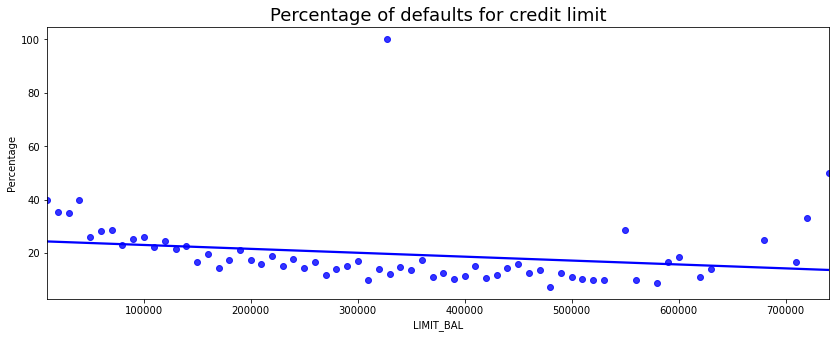

In [231]:
# plot for credit limit (defaulted)
g = sns.regplot(x='LIMIT_BAL', y ='Percentage', data=lb1, ci=None, color='blue')
g.figure.set_size_inches(14,5)
g.set_title('Percentage of defaults for credit limit', size=18);

As the credit limit increase, the percentage of clients defaulting decrease as the bank had given them a higher credit at the beginning due to a better credit rating score.

Lets look at the outlier with 100% to default.

In [232]:
lb1[lb1.Percentage==100]

LIMIT_BAL  DEFAULT  Counts  Percentage
65   327680.0        1       1       100.0

In [233]:
df[df.LIMIT_BAL == 327680]

ID  LIMIT_BAL  SEX  EDUCATION  AGE  PAY_1  PAY_2  PAY_3  PAY_4  \
12525  12526   327680.0    0          1   42      0      0      0      0   

       PAY_5  ...  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  \
12525      0  ...   243600.0   11219.0   11461.0    9100.0    8345.0   

       PAY_AMT5  PAY_AMT6  DEFAULT  MARRIAGE_others  MARRIAGE_single  
12525    7783.0    9200.0        1                0                1  

[1 rows x 26 columns]

Althought client ID 12526 paid every month from April to September 2005, he was still predicted to default. Probably because his bill amount is still high.

### Repayment status

We will group payment delay of 3 months and above together. We will also group -2, -1 and 0 as pay duly.

In [234]:
# Repayment status in September, 2005
df.PAY_1.value_counts()

 0    14737
-1     5686
 1     3688
-2     2759
 2     2667
 3      322
 4       76
 5       26
 8       19
 6       11
 7        9
Name: PAY_1, dtype: int64

In [235]:
change1 = df[(df.PAY_1 == 3) | (df.PAY_1 == 4) | (df.PAY_1 == 5) | (df.PAY_1 == 6) | (df.PAY_1 == 7) | (df.PAY_1 == 8)][['PAY_1']]
df.loc[change1.index, 'PAY_1'] = 3
df.loc[df[(df.PAY_1 == -2) | (df.PAY_1 == -1)][['PAY_1']].index, 'PAY_1'] = 0

In [236]:
# Repayment status in September, 2005
df.PAY_1.value_counts()

0    23182
1     3688
2     2667
3      463
Name: PAY_1, dtype: int64

In [237]:
# Repayment status in August, 2005
df.PAY_2.value_counts()

 0    15730
-1     6050
 2     3927
-2     3782
 3      326
 4       99
 1       28
 5       25
 7       20
 6       12
 8        1
Name: PAY_2, dtype: int64

In [238]:
change2 = df[(df.PAY_2 == 3) | (df.PAY_2 == 4) | (df.PAY_2 == 5) | (df.PAY_2 == 6) | (df.PAY_2 == 7) | (df.PAY_2 == 8)][['PAY_2']]
df.loc[change2.index, 'PAY_2'] = 3
df.loc[df[(df.PAY_2 == -2) | (df.PAY_2 == -1)][['PAY_2']].index, 'PAY_2'] = 0

In [239]:
# Repayment status in August, 2005
df.PAY_2.value_counts()

0    25562
2     3927
3      483
1       28
Name: PAY_2, dtype: int64

In [240]:
# Repayment status in July, 2005
df.PAY_3.value_counts()

 0    15764
-1     5938
-2     4085
 2     3819
 3      240
 4       76
 7       27
 6       23
 5       21
 1        4
 8        3
Name: PAY_3, dtype: int64

In [241]:
change3 = df[(df.PAY_3 == 3) | (df.PAY_3 == 4) | (df.PAY_3 == 5) | (df.PAY_3 == 6) | (df.PAY_3 == 7) | (df.PAY_3 == 8)][['PAY_3']]
df.loc[change3.index, 'PAY_3'] = 3
df.loc[df[(df.PAY_3 == -2) | (df.PAY_3 == -1)][['PAY_3']].index, 'PAY_3'] = 0

In [242]:
# Repayment status in July, 2005
df.PAY_3.value_counts()

0    25787
2     3819
3      390
1        4
Name: PAY_3, dtype: int64

In [243]:
# Repayment status in June, 2005
df.PAY_4.value_counts()

 0    16455
-1     5687
-2     4348
 2     3159
 3      180
 4       69
 7       58
 5       35
 6        5
 1        2
 8        2
Name: PAY_4, dtype: int64

In [244]:
change4 = df[(df.PAY_4 == 3) | (df.PAY_4 == 4) | (df.PAY_4 == 5) | (df.PAY_4 == 6) | (df.PAY_4 == 7) | (df.PAY_4 == 8)][['PAY_4']]
df.loc[change4.index, 'PAY_4'] = 3
df.loc[df[(df.PAY_4 == -2) | (df.PAY_4 == -1)][['PAY_4']].index, 'PAY_4'] = 0

In [245]:
# Repayment status in June, 2005
df.PAY_4.value_counts()

0    26490
2     3159
3      349
1        2
Name: PAY_4, dtype: int64

In [246]:
# Repayment status in May, 2005
df.PAY_5.value_counts()

 0    16947
-1     5539
-2     4546
 2     2626
 3      178
 4       84
 7       58
 5       17
 6        4
 8        1
Name: PAY_5, dtype: int64

In [247]:
change5 = df[(df.PAY_5 == 3) | (df.PAY_5 == 4) | (df.PAY_5 == 5) | (df.PAY_5 == 6) | (df.PAY_5 == 7) | (df.PAY_5 == 8)][['PAY_5']]
df.loc[change5.index, 'PAY_5'] = 3
df.loc[df[(df.PAY_5 == -2) | (df.PAY_5 == -1)][['PAY_5']].index, 'PAY_5'] = 0

In [248]:
# Repayment status in May, 2005
df.PAY_5.value_counts()

0    27032
2     2626
3      342
Name: PAY_5, dtype: int64

In [249]:
# Repayment status in April, 2005
df.PAY_6.value_counts()

 0    16286
-1     5740
-2     4895
 2     2766
 3      184
 4       49
 7       46
 6       19
 5       13
 8        2
Name: PAY_6, dtype: int64

In [250]:
change6 = df[(df.PAY_6 == 3) | (df.PAY_6 == 4) | (df.PAY_6 == 5) | (df.PAY_6 == 6) | (df.PAY_6 == 7) | (df.PAY_6 == 8)][['PAY_6']]
df.loc[change6.index, 'PAY_6'] = 3
df.loc[df[(df.PAY_6 == -2) | (df.PAY_6 == -1)][['PAY_6']].index, 'PAY_6'] = 0

In [251]:
# Repayment status in April, 2005
df.PAY_6.value_counts()

0    26921
2     2766
3      313
Name: PAY_6, dtype: int64

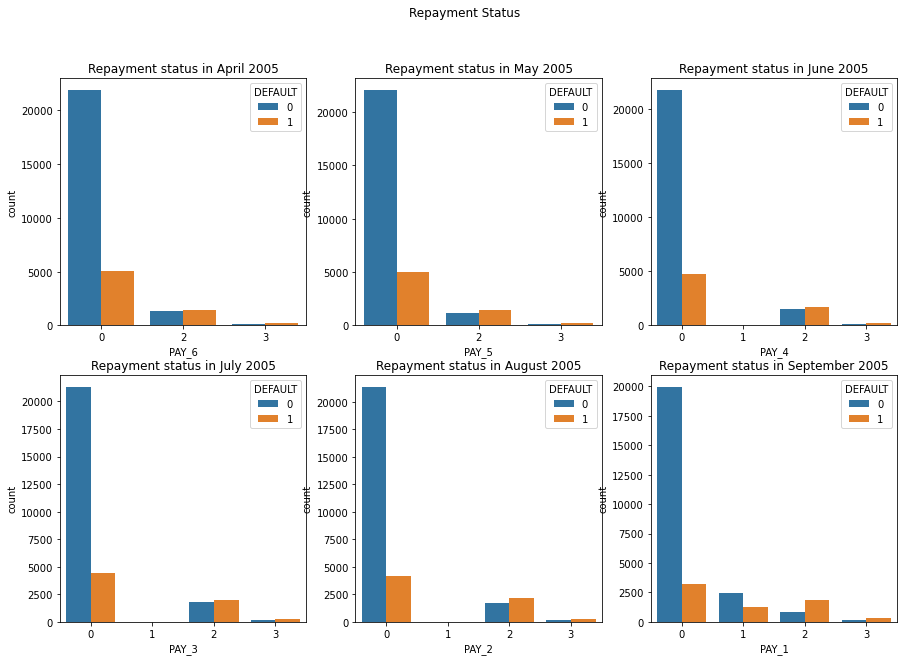

In [252]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Repayment Status')

sns.countplot(ax=axes[0,0], x='PAY_6', data=df, hue="DEFAULT")
axes[0,0].set_title('Repayment status in April 2005')

sns.countplot(ax=axes[0,1], x='PAY_5', data=df, hue="DEFAULT")
axes[0,1].set_title('Repayment status in May 2005')

sns.countplot(ax=axes[0,2], x='PAY_4', data=df, hue="DEFAULT")
axes[0,2].set_title('Repayment status in June 2005')

sns.countplot(ax=axes[1,0], x='PAY_3', data=df, hue="DEFAULT")
axes[1,0].set_title('Repayment status in July 2005')

sns.countplot(ax=axes[1,1], x='PAY_2', data=df, hue="DEFAULT")
axes[1,1].set_title('Repayment status in August 2005')

sns.countplot(ax=axes[1,2], x='PAY_1', data=df, hue="DEFAULT")
axes[1,2].set_title('Repayment status in September 2005');

Defaults seem to occur mostly when clients had a payment delay for more than 2 months.

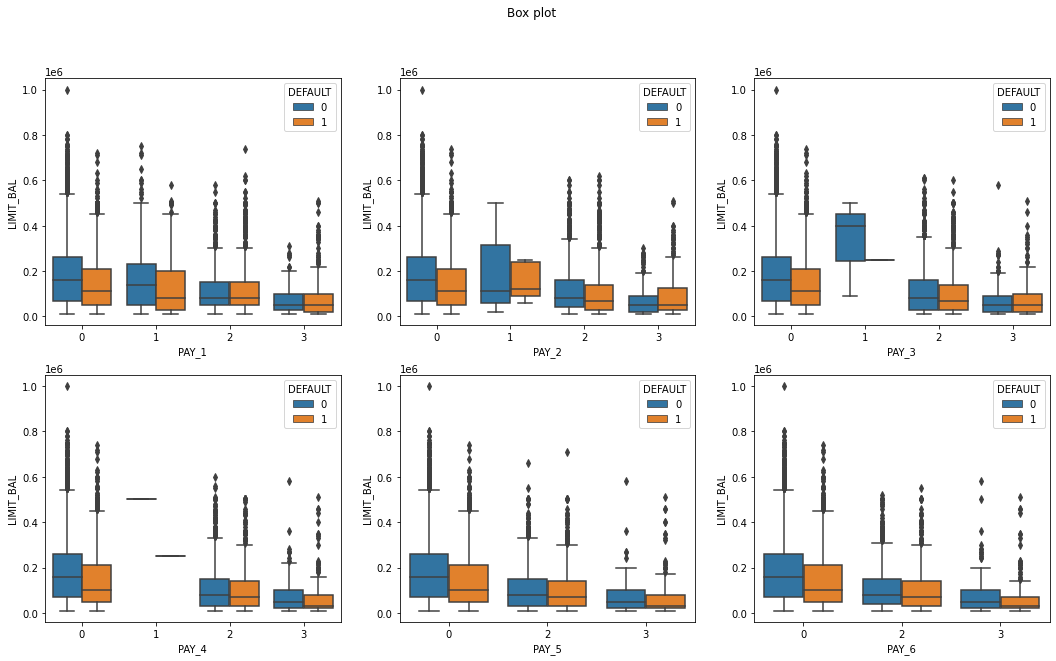

In [185]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

fig.suptitle('Box plot')

sns.boxplot(ax=axes[0, 0], data=df, x='PAY_1', y='LIMIT_BAL', hue='DEFAULT')
sns.boxplot(ax=axes[0, 1], data=df, x='PAY_2', y='LIMIT_BAL', hue='DEFAULT')
sns.boxplot(ax=axes[0, 2], data=df, x='PAY_3', y='LIMIT_BAL', hue='DEFAULT')
sns.boxplot(ax=axes[1, 0], data=df, x='PAY_4', y='LIMIT_BAL', hue='DEFAULT')
sns.boxplot(ax=axes[1, 1], data=df, x='PAY_5', y='LIMIT_BAL', hue='DEFAULT')
sns.boxplot(ax=axes[1, 2], data=df, x='PAY_6', y='LIMIT_BAL', hue='DEFAULT');

- Overall, there is higher variability of credit card limit given to clients who will not default the next month. 
- There is a outstanding outlier of a million dollars limit balance. 
- Almost all of the median credit limit for non defaulters are higher than defauters. 
- All outliers are seen at the top of the box plot as bank do not normally give high credit limit.
- There is no delay of 1 month for the month of April and May 2005.

In [186]:
df[df.LIMIT_BAL == 1000000]

LIMIT_BAL  SEX  EDUCATION  AGE  PAY_1  PAY_2  PAY_3  PAY_4  PAY_5  \
ID                                                                        
2198  1000000.0    1          3   47      0      0      0      0      0   

      PAY_6  ...  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  \
ID           ...                                                                
2198      0  ...   961664.0   50784.0   50723.0  896040.0   50000.0   50000.0   

      PAY_AMT6  DEFAULT  MARRIAGE_others  MARRIAGE_single  
ID                                                         
2198   50256.0        0                0                0  

[1 rows x 25 columns]

The highest card limit of 1 million dollars seems legit, with high bill amount and high payment as well. The client probably is a high income earner. She paid duly and although she still have balance to pay, she was predicted to not default.

### Heatmap

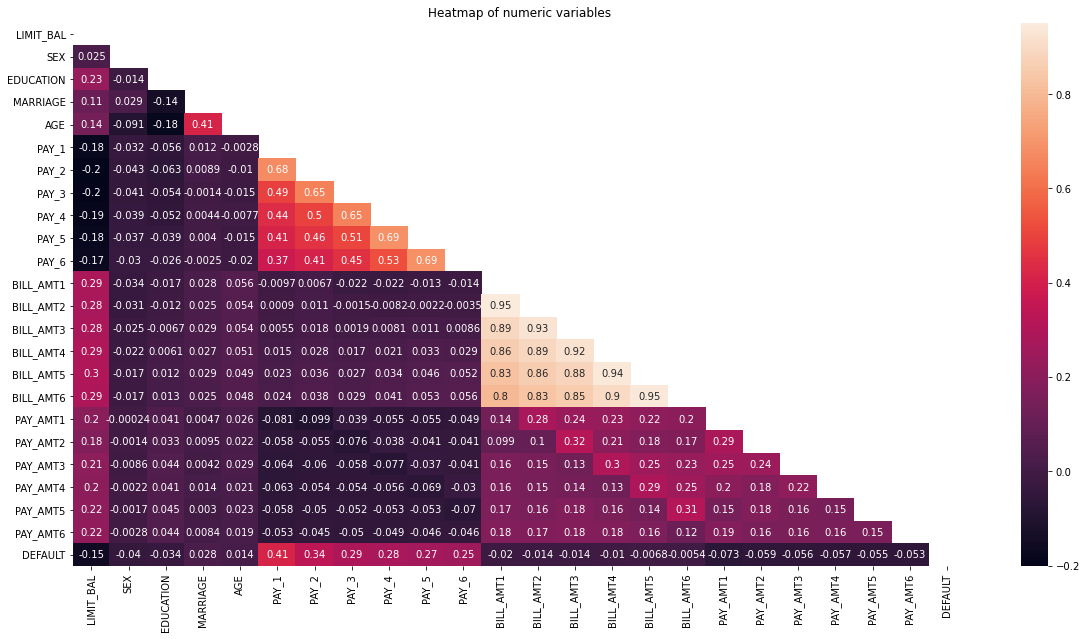

In [180]:
plt.figure(figsize=(20,10))
mask = np.triu(df[['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
                   'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 
                   'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'DEFAULT']].corr())
sns.heatmap(df[['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
                'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 
                'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'DEFAULT']].corr(), annot=True, mask=mask)
plt.title('Heatmap of numeric variables');

- Bill amounts have high positive correlation among themselves, especially in consecutive order.
- Moderate positive correlation between consecutive repayment status (e.g. PAY_1 and PAY_2)
- Default does not seem to have any strong correlation with any of the variables. The most correlated variables are repayment status.

### Bill and pay amount correlation

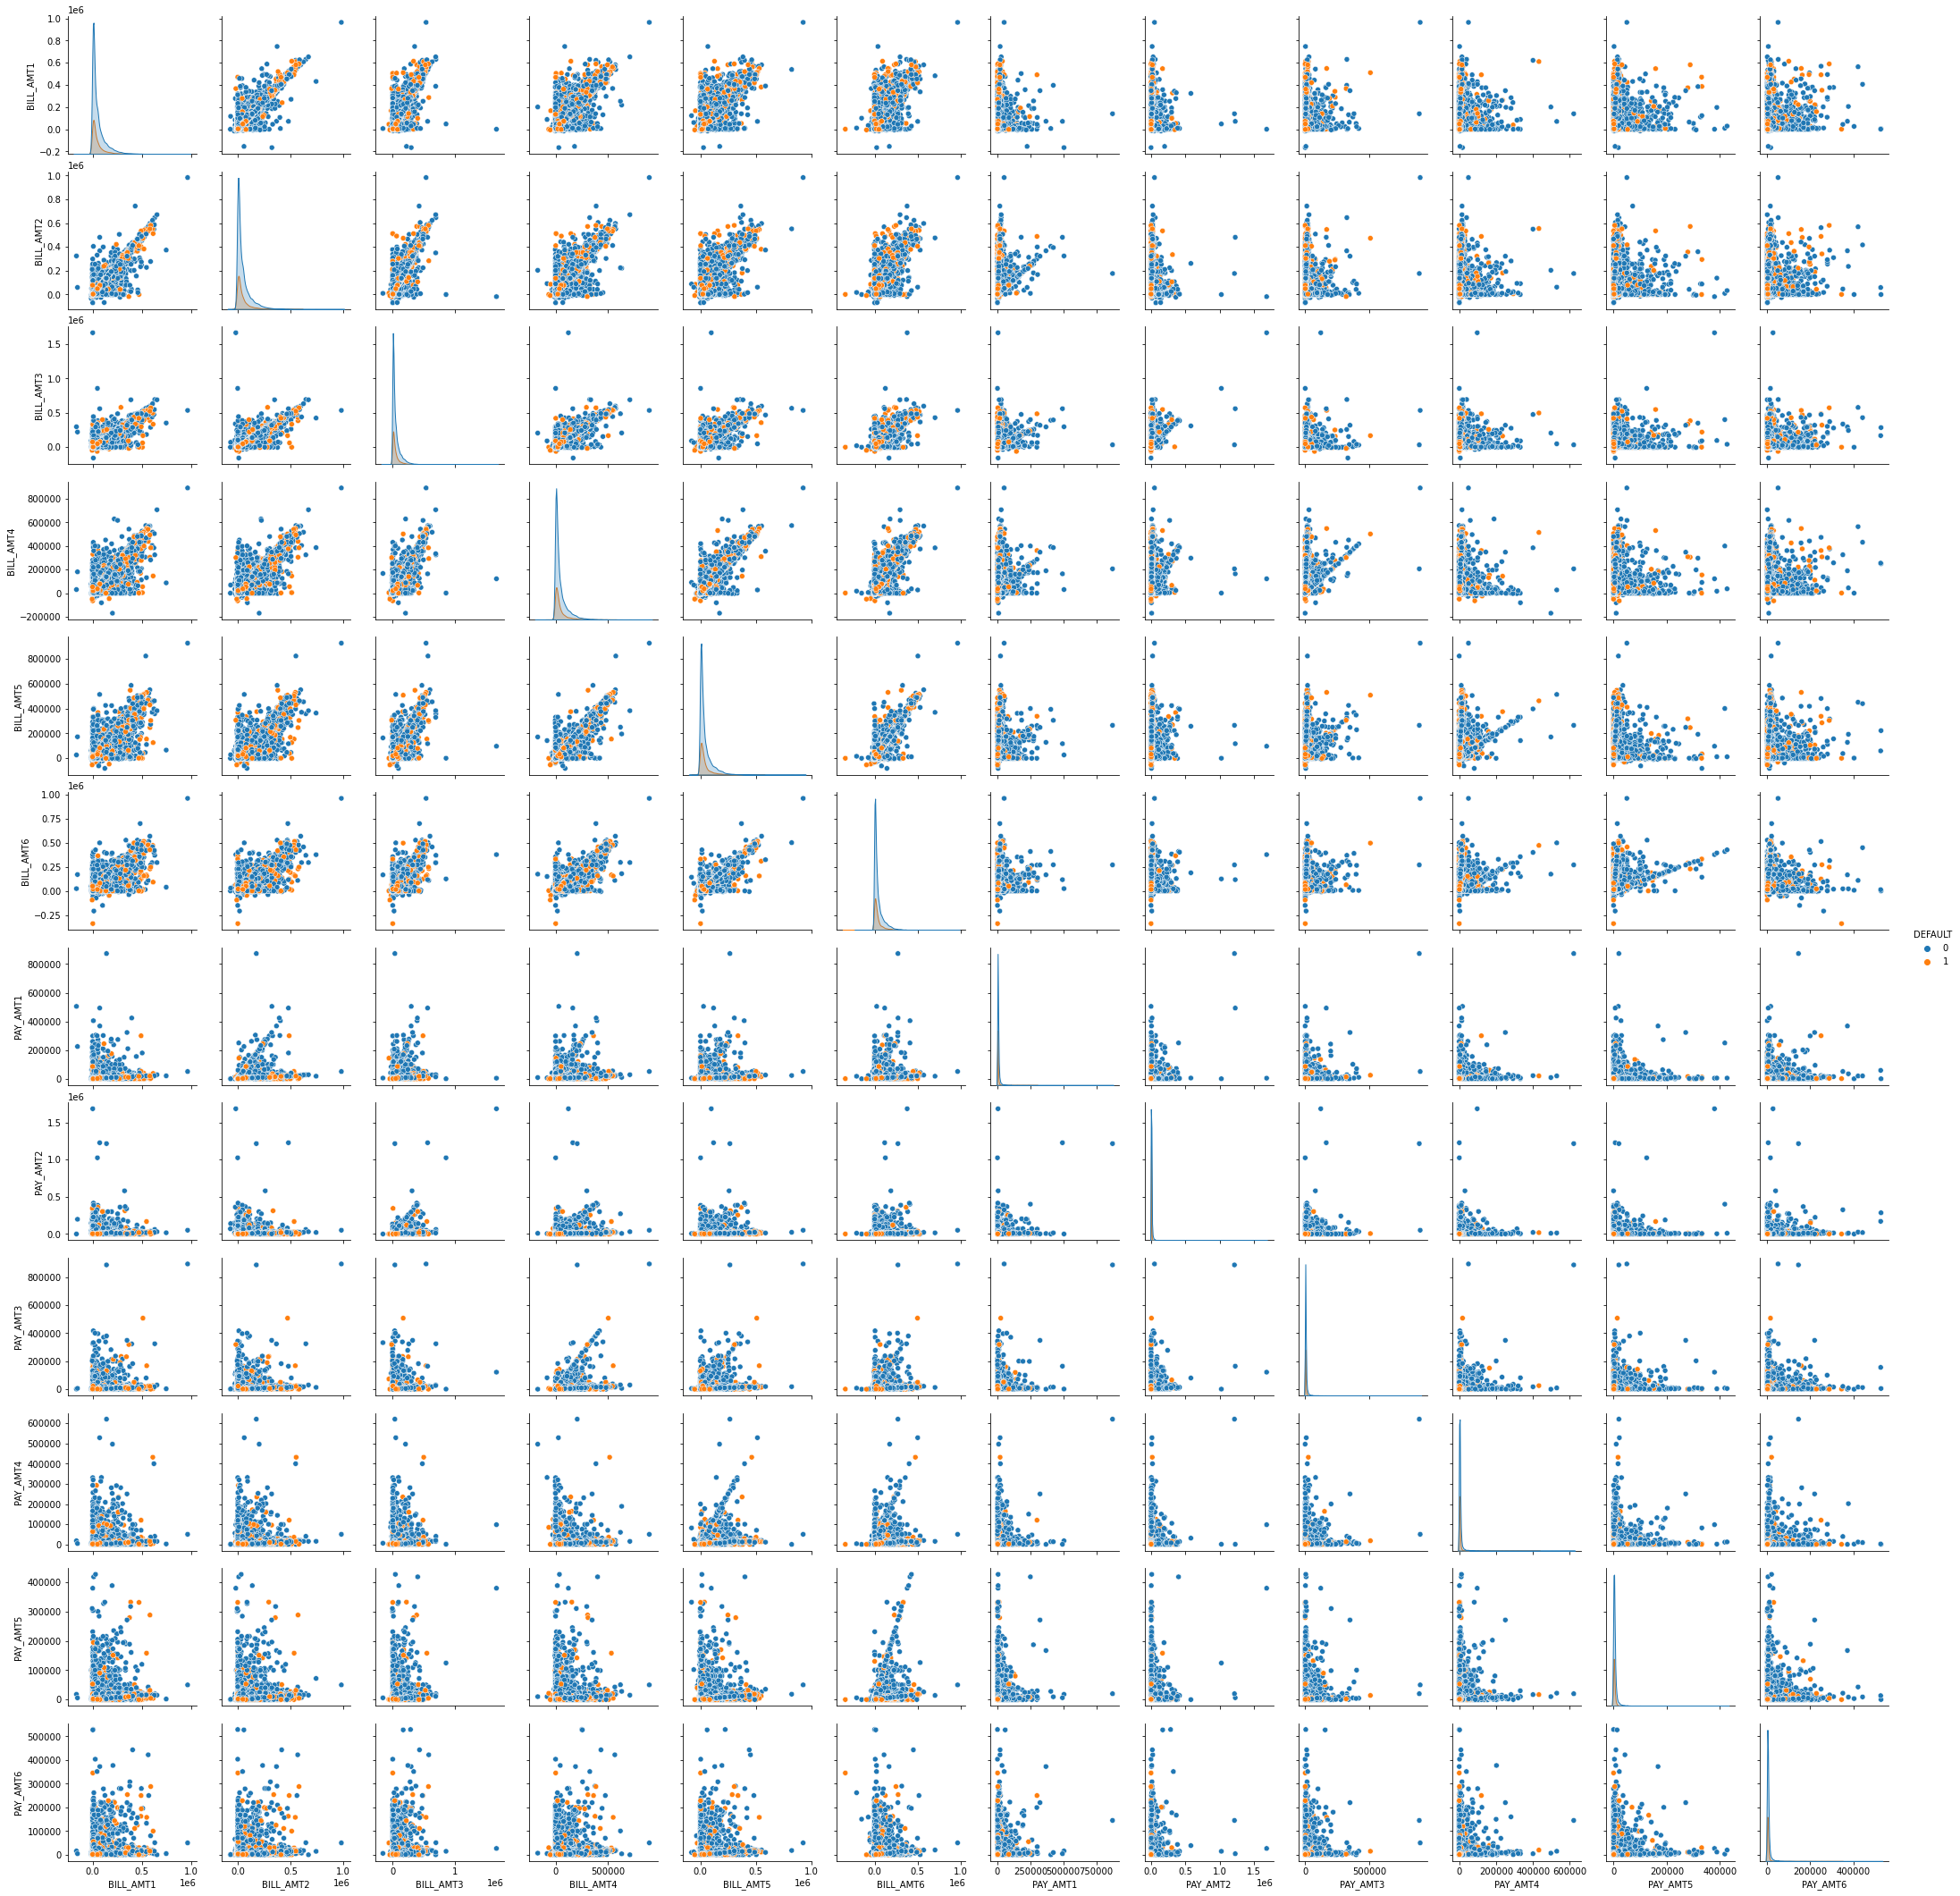

In [181]:
variables = ['BILL_AMT1', 'BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 
             'PAY_AMT3', 'PAY_AMT4','PAY_AMT5', 'PAY_AMT6']
sns.pairplot(df, x_vars=variables, y_vars=variables, hue='DEFAULT');

- There is a distinct straight line for the bill of the previous month and the pay amount for the next month. E.g. BILL_AMT6 (April) and PAY_AMT5 (May) etc. This are the clients who pay their entire bill statement the next month. We can also see that the data points making up the distinct straight line (y=x) are mostly not predicted to default. Refer to next graph for example.
- For the latest month, PAY_AMT1 (Sept), there is a larger predicted default clients with lower amount of payment.

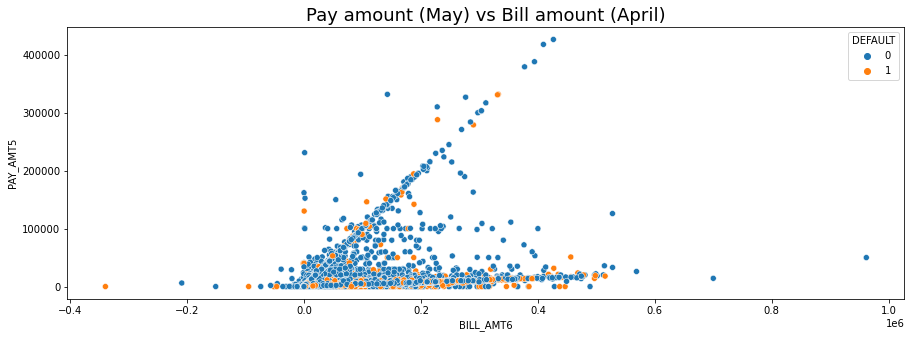

In [60]:
g = sns.scatterplot(x='BILL_AMT6', y='PAY_AMT5', data=df, hue='DEFAULT');
g.figure.set_size_inches(15,5)
g.set_title('Pay amount (May) vs Bill amount (April)', size=18);

There is a straight line (almost x=y) line formed between pay amount and bill amount(previous month). This shows that those clients were paying their previous month credit card bills.

Bill amount can be negative as well due to some client overpaying or maybe some rebates were credited into their account, which can be used to pay for bills next month or be refunded.

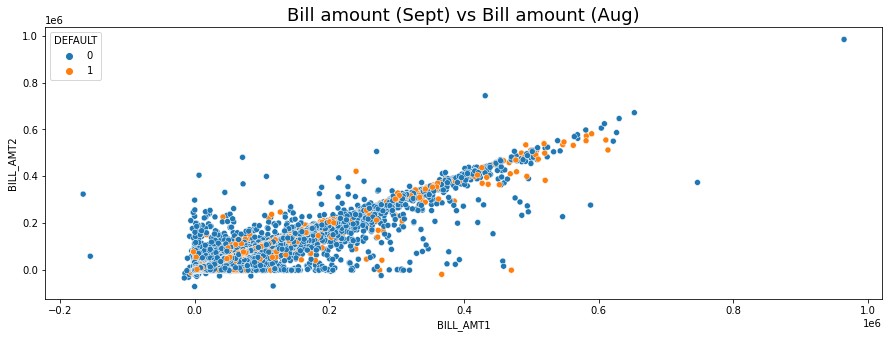

In [61]:
g = sns.scatterplot(x='BILL_AMT1', y='BILL_AMT2', data=df, hue='DEFAULT');
g.figure.set_size_inches(15,5)
g.set_title('Bill amount (Sept) vs Bill amount (Aug)', size=18);

When the previous bill amount is same as the bill next month, it is not clear if it is carried from the previous month due to no payment or if it is a recurring instalment payment.

In [62]:
df[df['BILL_AMT1'] == df['BILL_AMT2']]

ID  LIMIT_BAL  SEX  EDUCATION  AGE  PAY_1  PAY_2  PAY_3  PAY_4  \
9         10    20000.0    0          0   35      0      0      0      0   
18        19   360000.0    1          2   49      1      0      0      0   
19        20   180000.0    1          2   29      1      0      0      0   
21        22   120000.0    1          1   39      0      0      0      0   
45        46   210000.0    0          2   29      0      0      0      0   
...      ...        ...  ...        ...  ...    ...    ...    ...    ...   
29933  29934   190000.0    0          0   44      0      2      0      2   
29973  29974   230000.0    0          1   35      1      0      0      0   
29979  29980   180000.0    0          2   32      0      0      0      0   
29985  29986   240000.0    0          2   30      0      0      0      0   
29991  29992   210000.0    0          1   34      3      2      2      2   

       PAY_5  PAY_6  BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  \
9          0      0        0.0        0.0        0.0        0.0    13007.0   
18         0      0        0.0        0.0        0.0        0.0        0.0   
19         0      0        0.0        0.0        0.0        0.0        0.0   
21         0      0      316.0      316.0      316.0        0.0      632.0   
45         0      0        0.0        0.0        0.0        0.0        0.0   
...      ...    ...        ...        ...        ...        ...        ...   
29933      0      0      291.0      291.0      582.0      291.0      582.0   
29973      0      0        0.0        0.0        0.0        0.0        0.0   
29979      0      0        0.0        0.0        0.0        0.0        0.0   
29985      0      0        0.0        0.0        0.0        0.0        0.0   
29991      2      2     2500.0     2500.0     2500.0     2500.0     2500.0   

       BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  \
9        13912.0       0.0       0.0       0.0   13007.0    1122.0       0.0   
18           0.0       0.0       0.0       0.0       0.0       0.0       0.0   
19           0.0       0.0       0.0       0.0       0.0       0.0       0.0   
21         316.0     316.0     316.0       0.0     632.0     316.0       0.0   
45           0.0       0.0       0.0       0.0       0.0       0.0       0.0   
...          ...       ...       ...       ...       ...       ...       ...   
29933      291.0       0.0     582.0       0.0     582.0       0.0     291.0   
29973        0.0       0.0       0.0       0.0       0.0       0.0       0.0   
29979        0.0       0.0       0.0       0.0       0.0       0.0       0.0   
29985        0.0       0.0       0.0       0.0       0.0       0.0       0.0   
29991     2500.0       0.0       0.0       0.0       0.0       0.0       0.0   

       DEFAULT  MARRIAGE_others  MARRIAGE_single  
9            0                0                1  
18           0                0                0  
19           0                0                1  
21           1                0                0  
45           1                0                1  
...        ...              ...              ...  
29933        0                0                0  
29973        1                0                0  
29979        0                0                0  
29985        0                0                1  
29991        1                0                0  

[2634 rows x 26 columns]

In [253]:
#df.to_csv('./datasets/df_1.csv', index=False)

In [182]:
#df.to_csv('./datasets/regression.csv', index=False)

## Modeling

In [325]:
df = pd.read_csv('./datasets/df_1.csv')

In [326]:
df.head()

ID  LIMIT_BAL  SEX  EDUCATION  AGE  PAY_1  PAY_2  PAY_3  PAY_4  PAY_5  ...  \
0   1    20000.0    1          2   24      2      2      0      0      0  ...   
1   2   120000.0    1          2   26      0      2      0      0      0  ...   
2   3    90000.0    1          2   34      0      0      0      0      0  ...   
3   4    50000.0    1          2   37      0      0      0      0      0  ...   
4   5    50000.0    0          2   57      0      0      0      0      0  ...   

   BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  \
0        0.0       0.0     689.0       0.0       0.0       0.0       0.0   
1     3261.0       0.0    1000.0    1000.0    1000.0       0.0    2000.0   
2    15549.0    1518.0    1500.0    1000.0    1000.0    1000.0    5000.0   
3    29547.0    2000.0    2019.0    1200.0    1100.0    1069.0    1000.0   
4    19131.0    2000.0   36681.0   10000.0    9000.0     689.0     679.0   

   DEFAULT  MARRIAGE_others  MARRIAGE_single  
0        1                0                0  
1        1                0                1  
2        0                0                1  
3        0                0                0  
4        0                0                0  

[5 rows x 26 columns]

In [327]:
# set index to client ID
df.set_index('ID', inplace=True)
# drop pay_amt6 column
df.drop(columns=['PAY_AMT6'], axis=1, inplace=True)

In [328]:
# df_try['NOPAY'] = df_try.apply(lambda row: row['PAY_1'] + row['PAY_2'] + row['PAY_3'] + row['PAY_4'] + 
                               #row['PAY_5'] + row['PAY_6'], axis=1
# df_try.drop(columns=['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'], axis=1, inplace=True)
#df_try.drop(columns=['PAY_6', 'BILL_AMT6', 'PAY_AMT5', 'PAY_5', 'BILL_AMT5', 'PAY_AMT4'], axis=1, inplace=True)
#df_try['BILL_1,2'] = df_try['BILL_AMT1'] * df_try['BILL_AMT2']
#df_try['BILL_3,4'] = df_try['BILL_AMT3'] * df_try['BILL_AMT4']
#df_try.drop(columns=['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4'], axis=1, inplace=True)

In [329]:
y = df['DEFAULT']

In [330]:
X = df.drop(['DEFAULT'], axis=1)
# , 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'

In [332]:
X.head()

LIMIT_BAL  SEX  EDUCATION  AGE  PAY_1  PAY_2  PAY_3  PAY_4  PAY_5  PAY_6  \
ID                                                                             
1     20000.0    1          2   24      2      2      0      0      0      0   
2    120000.0    1          2   26      0      2      0      0      0      2   
3     90000.0    1          2   34      0      0      0      0      0      0   
4     50000.0    1          2   37      0      0      0      0      0      0   
5     50000.0    0          2   57      0      0      0      0      0      0   

    ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
ID  ...                                                                  
1   ...        0.0        0.0        0.0       0.0     689.0       0.0   
2   ...     3272.0     3455.0     3261.0       0.0    1000.0    1000.0   
3   ...    14331.0    14948.0    15549.0    1518.0    1500.0    1000.0   
4   ...    28314.0    28959.0    29547.0    2000.0    2019.0    1200.0   
5   ...    20940.0    19146.0    19131.0    2000.0   36681.0   10000.0   

    PAY_AMT4  PAY_AMT5  MARRIAGE_others  MARRIAGE_single  
ID                                                        
1        0.0       0.0                0                0  
2     1000.0       0.0                0                1  
3     1000.0    1000.0                0                1  
4     1100.0    1069.0                0                0  
5     9000.0     689.0                0                0  

[5 rows x 23 columns]

In [333]:
y.value_counts(normalize=True)

0    0.7788
1    0.2212
Name: DEFAULT, dtype: float64

In [334]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=12, test_size=0.2, stratify=y)

### Logistic Regression

Most commonly used classification model.

In [175]:
# pipeline
pipe_lr = Pipeline([
    ('scale', StandardScaler()),
    ('sampling', SMOTE()),
    ('lr', LogisticRegression())
])

# search over hyperparameters
pipe_lr_params = {
    'sampling__sampling_strategy': ['minority'], # 'auto', 'minority', 'not minority'
    'sampling__k_neighbors': [2], # 2,3,5
    'lr__penalty': ['none'], # l2, none
    #'lr__C': [0.7,0.9] # 0.1,0.5,0.7
}

# gridsearch
gs_lr = GridSearchCV(pipe_lr, pipe_lr_params, cv=5, scoring='roc_auc') 

# fit model
gs_lr.fit(X_train, y_train)

# best param
print(f'Best parameters: {gs_lr.best_params_}')
# ROC AUC score
print(f'Best CV ROC AUC score: {gs_lr.best_score_}')
print(f'Training ROC AUC score: {gs_lr.score(X_train, y_train)}')
print(f'Test ROC AUC score: {gs_lr.score(X_test, y_test)}')

Best parameters: {'lr__penalty': 'none', 'sampling__k_neighbors': 2, 'sampling__sampling_strategy': 'minority'}
Best CV ROC AUC score: 0.7593700857896482
Training ROC AUC score: 0.761992789738407
Test ROC AUC score: 0.7594979157632609


In [176]:
print(classification_report(y_test, gs_lr.predict(X_test)))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85      4673
           1       0.49      0.56      0.53      1327

    accuracy                           0.77      6000
   macro avg       0.68      0.70      0.69      6000
weighted avg       0.79      0.77      0.78      6000



In [177]:
# confusion matrix
cm1 = confusion_matrix(y_test, gs_lr.predict(X_test))
cm1_df = pd.DataFrame(
    cm1,
    columns = ['Pred Defaut', 'Pred No Default'],
    index=['Actual Default', 'Actual No Default']
)
cm1_df

Pred Defaut  Pred No Default
Actual Default            3897              776
Actual No Default          578              749

In [182]:
e_coef = np.exp(gs_lr.best_estimator_.named_steps['lr'].coef_)
pd.DataFrame(e_coef[0], 
             X.columns, 
             columns=['e^coef']).sort_values(by='e^coef', ascending=False)

e^coef
PAY_1            1.919304
BILL_AMT3        1.261737
BILL_AMT6        1.121963
BILL_AMT2        1.110733
PAY_4            1.107575
PAY_6            1.103892
PAY_3            1.101249
PAY_2            1.065693
PAY_5            1.041482
AGE              1.016309
MARRIAGE_others  0.993498
PAY_AMT3         0.982036
EDUCATION        0.981351
SEX              0.938361
BILL_AMT5        0.933597
PAY_AMT4         0.927948
PAY_AMT5         0.925504
MARRIAGE_single  0.914330
BILL_AMT4        0.890348
LIMIT_BAL        0.824273
PAY_AMT2         0.806262
BILL_AMT1        0.803368
PAY_AMT1         0.798209

For every increase in 1 unit of payment delay in the most recent month, there is 1.9 times more likely a client will default the next month.

### Random Forest

A type of ensemble machine learning algorithm that uses Bootstrap Aggregation or bagging. Bagging conducts random resampling with replacement to create multiple models and aggregates the predictions. Random forest selects a random subset of features at each node, de-correlating the trees.

In [201]:
pipe_rf = Pipeline([
    ('scale', StandardScaler()),
    ('sampling', SMOTE()),
    ('rf', RandomForestClassifier(random_state=12))
])

# search over hyperparameters
pipe_rf_params = {
    'sampling__sampling_strategy': ['minority'],
    'sampling__k_neighbors': [3], #2,3,4
    'rf__n_estimators': [3000], #1000,1400,1800,2000,2800
    'rf__max_depth': [40], #20,21,25,30,40
    'rf__min_samples_leaf': [8], #2,4,5,7,8
}

# gridsearch
gs_rf = GridSearchCV(pipe_rf, param_grid=pipe_rf_params, cv=5, scoring='roc_auc')

# fit model
gs_rf.fit(X_train, y_train)

# best parameters and ROC AUC scores
print('Best parameters: ', gs_rf.best_params_)
print('Best CV ROC AUC score: ', gs_rf.best_score_)
print('Training ROC AUC score:', gs_rf.score(X_train, y_train))
print('Validation ROC AUC score:', gs_rf.score(X_test, y_test))

Best parameters:  {'rf__max_depth': 40, 'rf__min_samples_leaf': 8, 'rf__n_estimators': 3000, 'sampling__k_neighbors': 3, 'sampling__sampling_strategy': 'minority'}
Best CV ROC AUC score:  0.7702018190034736
Training ROC AUC score: 0.944811908118711
Validation ROC AUC score: 0.7686689121927486


In [202]:
print(classification_report(y_test, gs_rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.87      0.84      0.85      4673
           1       0.49      0.55      0.52      1327

    accuracy                           0.78      6000
   macro avg       0.68      0.70      0.69      6000
weighted avg       0.79      0.78      0.78      6000



In [203]:
# confusion matrix
cm2 = confusion_matrix(y_test, gs_rf.predict(X_test))
cm2_df = pd.DataFrame(
    cm2,
    columns = ['Pred Defaut', 'Pred No Default'],
    index=['Actual Default', 'Actual No Default']
)
cm2_df

Pred Defaut  Pred No Default
Actual Default            3926              747
Actual No Default          595              732

### XGBoost classifier

XGBoost (eXtreme Gradient Boosting) is a decision-tree-based ensemble technique that uses a gradient boosting algorithm.

In [336]:
# pipeline
pipe_xgb = Pipeline([
    ('scale', StandardScaler()),
    ('sampling', SMOTE()),
    ('xgb', XGBClassifier(use_label_encoder=False, random_state=12))])

# search over hyperparameters
pipe_xgb_params = {
    'xgb__max_depth': [4], # 4,5,9
    # how deeply each tree grow
    'xgb__learning_rate': [0.01], # 0.01,0.05,0.1
    # step size shrinkage used to prevent overfitting
    'xgb__gamma': [0.4], # 0.1,0.3,0.4,0.5
    # min loss reduction required to make a further partition on a leaf node of the tree
    'xgb__subsample': [0.8], #0.6,0.8,0.9
    # % of sample used per tree
    'xgb__eval_metric': ['error'], 
    # binary classification error rate
    'xgb__n_estimators': [400], # 300,400,500
}

# gridsearch
gs_xgb = GridSearchCV(pipe_xgb, pipe_xgb_params, cv=5, scoring='roc_auc') 

# fit model
gs_xgb.fit(X_train, y_train)

# best param
print(f'Best parameters: {gs_xgb.best_params_}')
# ROC AUC score
print(f'Best CV ROC AUC score: {gs_xgb.best_score_}')
print(f'Training ROC AUC score: {gs_xgb.score(X_train, y_train)}')
print(f'Test ROC AUC score: {gs_xgb.score(X_test, y_test)}')

Best parameters: {'xgb__eval_metric': 'error', 'xgb__gamma': 0.4, 'xgb__learning_rate': 0.01, 'xgb__max_depth': 4, 'xgb__n_estimators': 400, 'xgb__subsample': 0.8}
Best CV ROC AUC score: 0.7718415964593495
Training ROC AUC score: 0.7885001488302202
Test ROC AUC score: 0.7701911492385751


In [337]:
print(classification_report(y_test, gs_xgb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85      4673
           1       0.49      0.57      0.52      1327

    accuracy                           0.77      6000
   macro avg       0.68      0.70      0.69      6000
weighted avg       0.79      0.77      0.78      6000



In [338]:
# confusion matrix
cm3 = confusion_matrix(y_test, gs_xgb.predict(X_test))
cm3_df = pd.DataFrame(
    cm3,
    columns = ['Pred Defaut', 'Pred No Default'],
    index=['Actual Default', 'Actual No Default']
)
cm3_df

Pred Defaut  Pred No Default
Actual Default            3880              793
Actual No Default          576              751

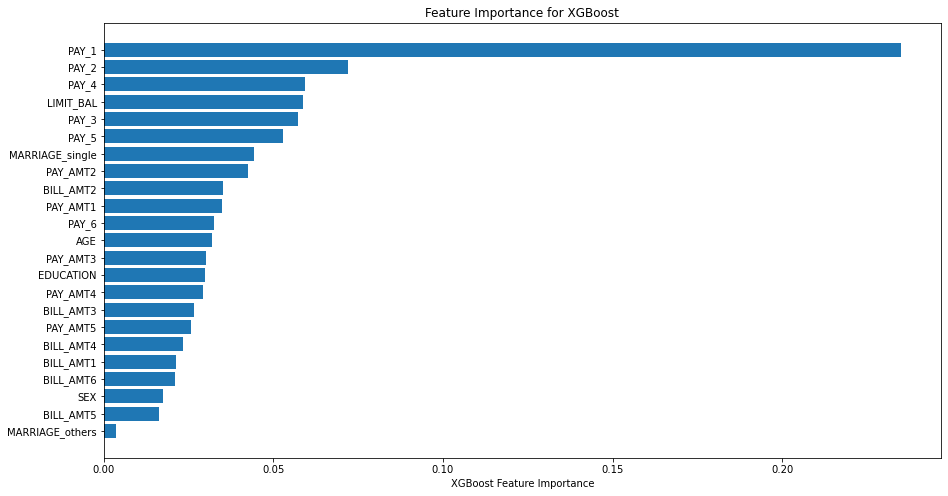

In [267]:
sorted_idx = gs_xgb.best_estimator_._final_estimator.feature_importances_.argsort()
plt.figure(figsize=(15,8))
plt.barh(X.columns[sorted_idx], gs_xgb.best_estimator_._final_estimator.feature_importances_[sorted_idx])
plt.title('Feature Importance for XGBoost')
plt.xlabel("XGBoost Feature Importance");

PAY_1 is the most important feature for generating a prediction, followed by PAY_2 and LIMIT_BAL.

Out of all the 3 classification models built, XGBoost achieved the highest ROC AUC score on the test set. The model obtained an ROC AUC of 0.77 on the test set, outperforming the baseline score of 0.5. This means that there is a 77% chance that the model will be able to distinguish between the positive and negative class (good class separation).

### Save results in dataframe

In [339]:
# risk of default and predicted default
xgb_proba = gs_xgb.predict_proba(X_test)
xgb_predict = gs_xgb.predict(X_test)

In [341]:
results = pd.DataFrame({'ID': X_test.index, 'default_risk': gs_xgb.predict_proba(X_test)[:,1], 'pred': gs_xgb.predict(X_test)})
results

ID  default_risk  pred
0     22765      0.228115     0
1     16368      0.340600     0
2      7452      0.539101     1
3      2037      0.200456     0
4     24229      0.568793     1
...     ...           ...   ...
5995  22699      0.413748     0
5996  23142      0.383648     0
5997  23093      0.431319     0
5998   5933      0.532820     1
5999   3017      0.451704     0

[6000 rows x 3 columns]

In [342]:
results.to_csv('./datasets/results.csv')

## Regression models

#### Predict how much a client is able to pay for September 2005

### Linear Regression

Most commonly used regression model. However, linearity assumption has to be met.

In [276]:
data = pd.read_csv('./datasets/regression.csv')

In [277]:
data.head()

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_1  PAY_2  PAY_3  PAY_4  \
0   1    20000.0    1          2         2   24      2      2      0      0   
1   2   120000.0    1          2         1   26      0      2      0      0   
2   3    90000.0    1          2         1   34      0      0      0      0   
3   4    50000.0    1          2         2   37      0      0      0      0   
4   5    50000.0    0          2         2   57      0      0      0      0   

   ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0  ...        0.0        0.0        0.0       0.0     689.0       0.0   
1  ...     3272.0     3455.0     3261.0       0.0    1000.0    1000.0   
2  ...    14331.0    14948.0    15549.0    1518.0    1500.0    1000.0   
3  ...    28314.0    28959.0    29547.0    2000.0    2019.0    1200.0   
4  ...    20940.0    19146.0    19131.0    2000.0   36681.0   10000.0   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  DEFAULT  
0       0.0       0.0       0.0        1  
1    1000.0       0.0    2000.0        1  
2    1000.0    1000.0    5000.0        0  
3    1100.0    1069.0    1000.0        0  
4    9000.0     689.0     679.0        0  

[5 rows x 25 columns]

In [278]:
# set index to client ID
data.set_index('ID', inplace=True)
# set y values
y = data.PAY_AMT1

In [279]:
data.head()

LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_1  PAY_2  PAY_3  PAY_4  \
ID                                                                         
1     20000.0    1          2         2   24      2      2      0      0   
2    120000.0    1          2         1   26      0      2      0      0   
3     90000.0    1          2         1   34      0      0      0      0   
4     50000.0    1          2         2   37      0      0      0      0   
5     50000.0    0          2         2   57      0      0      0      0   

    PAY_5  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
ID         ...                                                                  
1       0  ...        0.0        0.0        0.0       0.0     689.0       0.0   
2       0  ...     3272.0     3455.0     3261.0       0.0    1000.0    1000.0   
3       0  ...    14331.0    14948.0    15549.0    1518.0    1500.0    1000.0   
4       0  ...    28314.0    28959.0    29547.0    2000.0    2019.0    1200.0   
5       0  ...    20940.0    19146.0    19131.0    2000.0   36681.0   10000.0   

    PAY_AMT4  PAY_AMT5  PAY_AMT6  DEFAULT  
ID                                         
1        0.0       0.0       0.0        1  
2     1000.0       0.0    2000.0        1  
3     1000.0    1000.0    5000.0        0  
4     1100.0    1069.0    1000.0        0  
5     9000.0     689.0     679.0        0  

[5 rows x 24 columns]

In [186]:
cor = data.corr()
cor_var = cor['PAY_AMT1']
features_high_corr = abs(cor_var[cor_var > 0.2])
features_high_corr.sort_values()

BILL_AMT5    0.217031
BILL_AMT4    0.233012
BILL_AMT3    0.244335
PAY_AMT3     0.252191
BILL_AMT2    0.280365
PAY_AMT2     0.285576
PAY_AMT1     1.000000
Name: PAY_AMT1, dtype: float64

Very few variables are correlated with PAY_AMT1. The highest correlated variable is PAY_AMT2, which is in the little correlation range. We will try using PAY_AMT to create polynomial features as bill amount has negative values which caused the predictions to be negative as well.

### Visualise correlation between features and PAY_AMT1

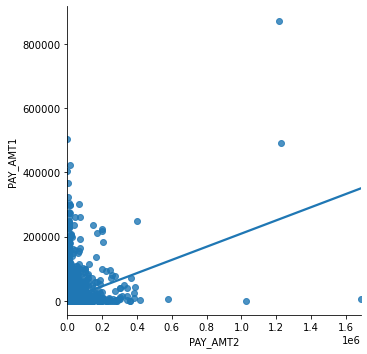

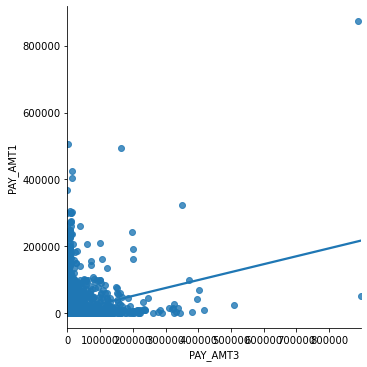

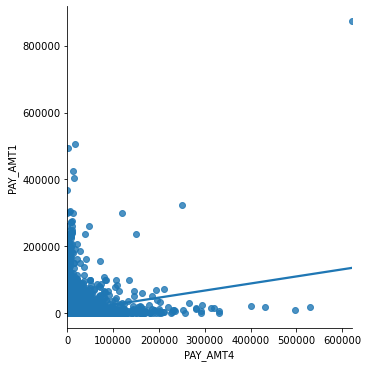

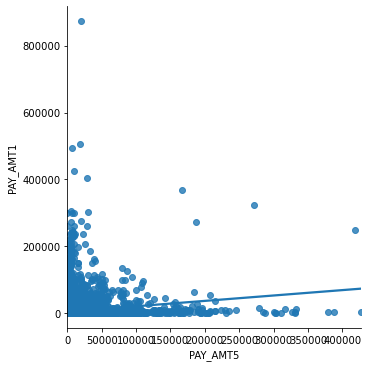

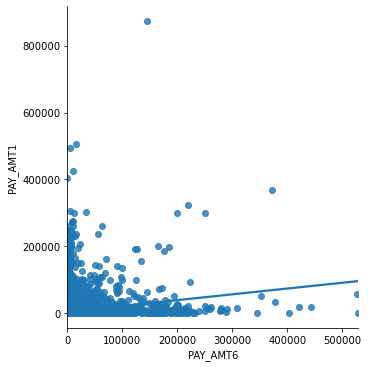

In [129]:
sns.lmplot(x='PAY_AMT2', y='PAY_AMT1', data=data, ci=None);
sns.lmplot(x='PAY_AMT3', y='PAY_AMT1', data=data, ci=None);
sns.lmplot(x='PAY_AMT4', y='PAY_AMT1', data=data, ci=None);
sns.lmplot(x='PAY_AMT5', y='PAY_AMT1', data=data, ci=None);
sns.lmplot(x='PAY_AMT6', y='PAY_AMT1', data=data, ci=None);

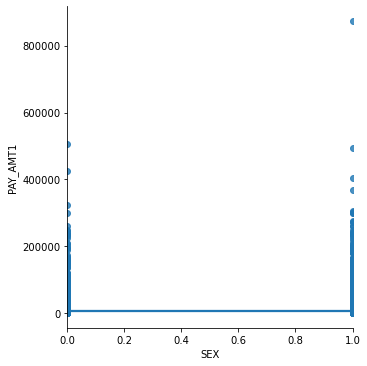

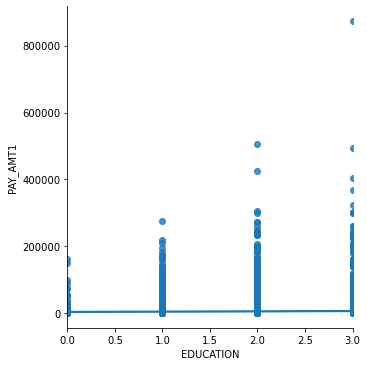

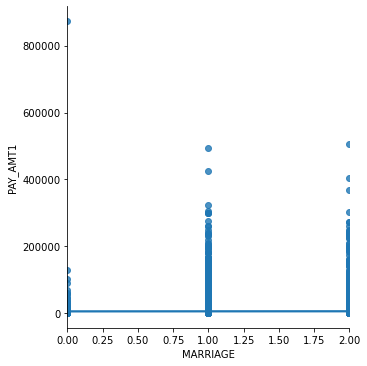

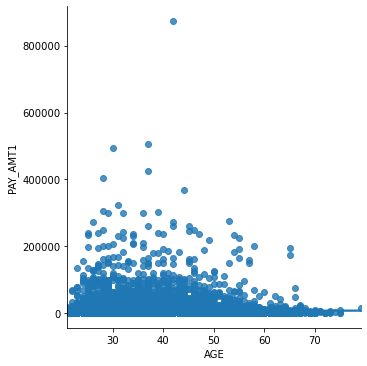

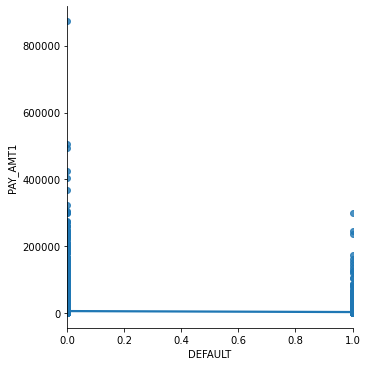

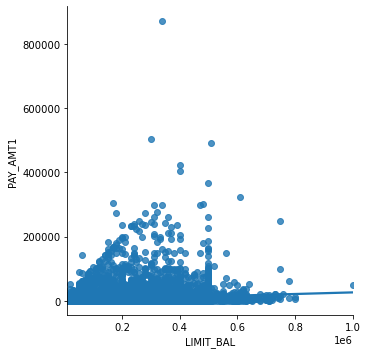

In [7]:
sns.lmplot(x='SEX', y='PAY_AMT1', data=data, ci=None);
sns.lmplot(x='EDUCATION', y='PAY_AMT1', data=data, ci=None);
sns.lmplot(x='MARRIAGE', y='PAY_AMT1', data=data, ci=None);
sns.lmplot(x='AGE', y='PAY_AMT1', data=data, ci=None);
sns.lmplot(x='DEFAULT', y='PAY_AMT1', data=data, ci=None);
sns.lmplot(x='LIMIT_BAL', y='PAY_AMT1', data=data, ci=None);

Categorical variabes have low correlation with PAY_AMT1. We will not use these features to predict PAY_AMT1.

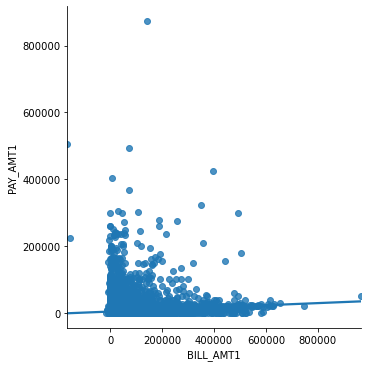

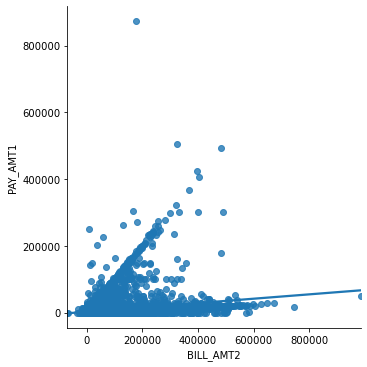

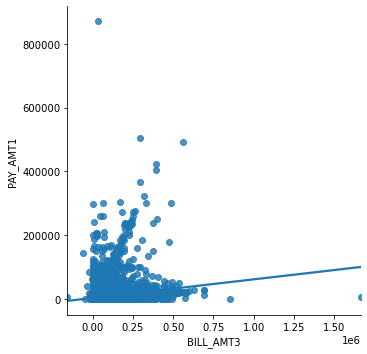

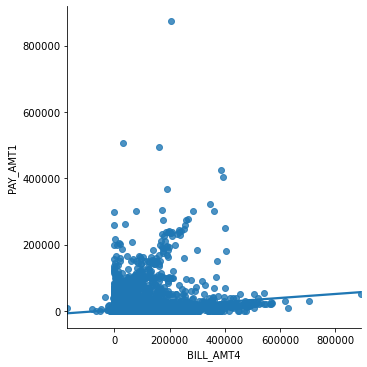

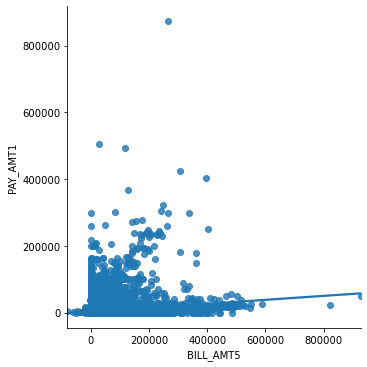

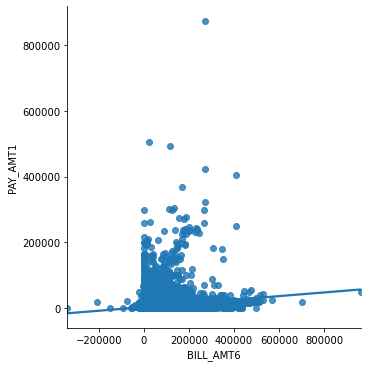

In [137]:
sns.lmplot(x='BILL_AMT1', y='PAY_AMT1', data=data, ci=None);
sns.lmplot(x='BILL_AMT2', y='PAY_AMT1', data=data, ci=None);
sns.lmplot(x='BILL_AMT3', y='PAY_AMT1', data=data, ci=None);
sns.lmplot(x='BILL_AMT4', y='PAY_AMT1', data=data, ci=None);
sns.lmplot(x='BILL_AMT5', y='PAY_AMT1', data=data, ci=None);
sns.lmplot(x='BILL_AMT6', y='PAY_AMT1', data=data, ci=None);

Bill_AMT1 to BILL_AMT6 have low correlation with PAY_AMT1.

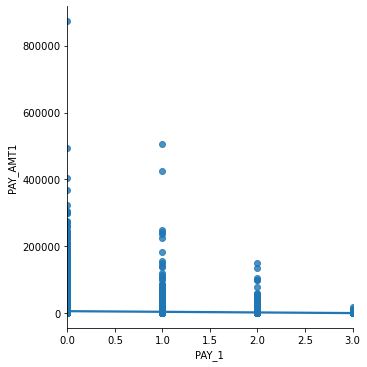

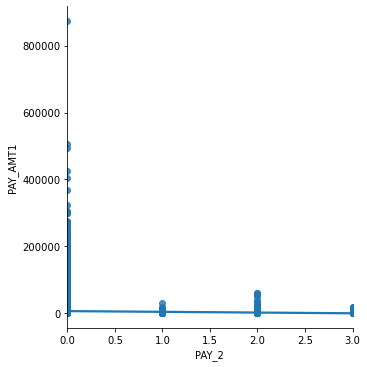

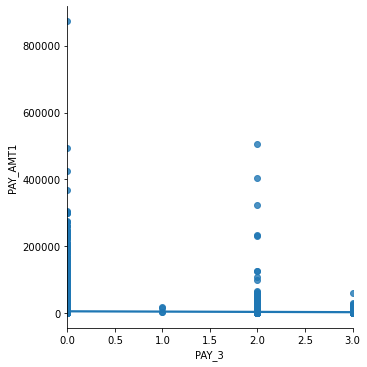

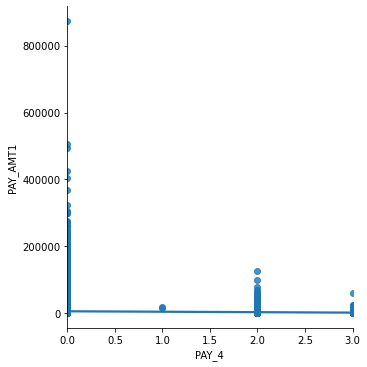

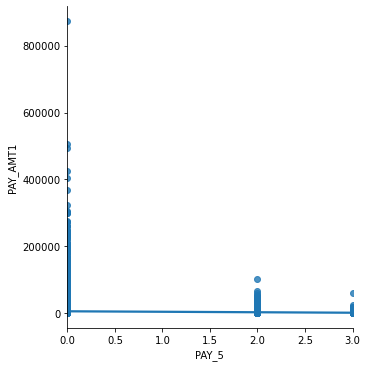

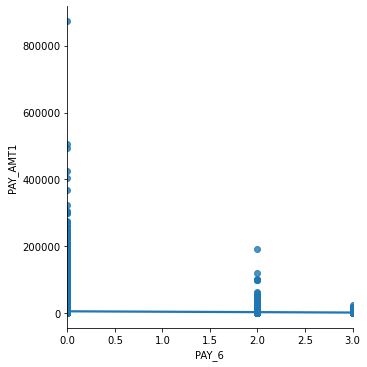

In [141]:
sns.lmplot(x='PAY_1', y='PAY_AMT1', data=data, ci=None);
sns.lmplot(x='PAY_2', y='PAY_AMT1', data=data, ci=None);
sns.lmplot(x='PAY_3', y='PAY_AMT1', data=data, ci=None);
sns.lmplot(x='PAY_4', y='PAY_AMT1', data=data, ci=None);
sns.lmplot(x='PAY_5', y='PAY_AMT1', data=data, ci=None);
sns.lmplot(x='PAY_6', y='PAY_AMT1', data=data, ci=None);

PAY_1 to PAY_6 have close to none linear correlation with PAY_AMT1. We will remove these features to predict PAY_AMT1.

In [283]:
X = data.drop(columns=['DEFAULT', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'DEFAULT', 'PAY_AMT1', 
                       'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 
                       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5','BILL_AMT6', ], axis=1)

In [284]:
X

PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6
ID                                                     
1         689.0       0.0       0.0       0.0       0.0
2        1000.0    1000.0    1000.0       0.0    2000.0
3        1500.0    1000.0    1000.0    1000.0    5000.0
4        2019.0    1200.0    1100.0    1069.0    1000.0
5       36681.0   10000.0    9000.0     689.0     679.0
...         ...       ...       ...       ...       ...
29996   20000.0    5003.0    3047.0    5000.0    1000.0
29997    3526.0    8998.0     129.0       0.0       0.0
29998       0.0   22000.0    4200.0    2000.0    3100.0
29999    3409.0    1178.0    1926.0   52964.0    1804.0
30000    1800.0    1430.0    1000.0    1000.0    1000.0

[30000 rows x 5 columns]

In [289]:
X.index

Int64Index([    1,     2,     3,     4,     5,     6,     7,     8,     9,
               10,
            ...
            29991, 29992, 29993, 29994, 29995, 29996, 29997, 29998, 29999,
            30000],
           dtype='int64', name='ID', length=30000)

### Generate polynomial and interaction features

In [285]:
poly = PolynomialFeatures(include_bias=False, degree=6)

In [286]:
X_poly = poly.fit_transform(X)

In [290]:
poly_df = pd.DataFrame(X_poly, 
                       columns=poly.get_feature_names(['PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']), 
                       index=X.index)

In [291]:
poly_df

PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6    PAY_AMT2^2  \
ID                                                                      
1         689.0       0.0       0.0       0.0       0.0  4.747210e+05   
2        1000.0    1000.0    1000.0       0.0    2000.0  1.000000e+06   
3        1500.0    1000.0    1000.0    1000.0    5000.0  2.250000e+06   
4        2019.0    1200.0    1100.0    1069.0    1000.0  4.076361e+06   
5       36681.0   10000.0    9000.0     689.0     679.0  1.345496e+09   
...         ...       ...       ...       ...       ...           ...   
29996   20000.0    5003.0    3047.0    5000.0    1000.0  4.000000e+08   
29997    3526.0    8998.0     129.0       0.0       0.0  1.243268e+07   
29998       0.0   22000.0    4200.0    2000.0    3100.0  0.000000e+00   
29999    3409.0    1178.0    1926.0   52964.0    1804.0  1.162128e+07   
30000    1800.0    1430.0    1000.0    1000.0    1000.0  3.240000e+06   

       PAY_AMT2 PAY_AMT3  PAY_AMT2 PAY_AMT4  PAY_AMT2 PAY_AMT5  \
ID                                                               
1                    0.0                0.0                0.0   
2              1000000.0          1000000.0                0.0   
3              1500000.0          1500000.0          1500000.0   
4              2422800.0          2220900.0          2158311.0   
5            366810000.0        330129000.0         25273209.0   
...                  ...                ...                ...   
29996        100060000.0         60940000.0        100000000.0   
29997         31726948.0           454854.0                0.0   
29998                0.0                0.0                0.0   
29999          4015802.0          6565734.0        180554276.0   
30000          2574000.0          1800000.0          1800000.0   

       PAY_AMT2 PAY_AMT6  ...  PAY_AMT4 PAY_AMT5^2 PAY_AMT6^3  \
ID                        ...                                   
1                    0.0  ...                    0.000000e+00   
2              2000000.0  ...                    0.000000e+00   
3              7500000.0  ...                    1.250000e+20   
4              2019000.0  ...                    1.257037e+18   
5             24906399.0  ...                    1.337489e+18   
...                  ...  ...                             ...   
29996         20000000.0  ...                    7.617500e+19   
29997                0.0  ...                    0.000000e+00   
29998                0.0  ...                    5.004888e+20   
29999          6149836.0  ...                    3.171958e+22   
30000          1800000.0  ...                    1.000000e+18   

       PAY_AMT4 PAY_AMT5 PAY_AMT6^4  PAY_AMT4 PAY_AMT6^5    PAY_AMT5^6  \
ID                                                                       
1                      0.000000e+00         0.000000e+00  0.000000e+00   
2                      0.000000e+00         3.200000e+19  0.000000e+00   
3                      6.250000e+20         3.125000e+21  1.000000e+18   
4                      1.175900e+18         1.100000e+18  1.492335e+18   
5                      1.318077e+18         1.298947e+18  1.069831e+17   
...                             ...                  ...           ...   
29996                  1.523500e+19         3.047000e+18  1.562500e+22   
29997                  0.000000e+00         0.000000e+00  0.000000e+00   
29998                  7.757576e+20         1.202424e+21  6.400000e+19   
29999                  1.080397e+21         3.679925e+19  2.207418e+28   
30000                  1.000000e+18         1.000000e+18  1.000000e+18   

       PAY_AMT5^5 PAY_AMT6  PAY_AMT5^4 PAY_AMT6^2  PAY_AMT5^3 PAY_AMT6^3  \
ID                                                                         
1             0.000000e+00           0.000000e+00           0.000000e+00   
2             0.000000e+00           0.000000e+00           0.000000e+00   
3             5.000000e+18           2.500000e+19           1.250000e+20   
4        

In [292]:
poly_df['PAY_AMT1'] = data.PAY_AMT1

In [221]:
cor = poly_df.corr()
cor_var = cor['PAY_AMT1']
features_high_corr = abs(cor_var[cor_var > 0.325])
features_high_corr.sort_values()

PAY_AMT3 PAY_AMT4 PAY_AMT6      0.325075
PAY_AMT3 PAY_AMT4 PAY_AMT6^2    0.325706
PAY_AMT3 PAY_AMT4               0.330547
PAY_AMT2 PAY_AMT3               0.335547
PAY_AMT1                        1.000000
Name: PAY_AMT1, dtype: float64

We will use features that have more than 0.325 correlation.

In [293]:
X = poly_df[['PAY_AMT2 PAY_AMT3', 'PAY_AMT3 PAY_AMT4', 'PAY_AMT3 PAY_AMT4 PAY_AMT6', 
             'PAY_AMT3 PAY_AMT4 PAY_AMT6^2', 'PAY_AMT1']]

In [294]:
X

PAY_AMT2 PAY_AMT3  PAY_AMT3 PAY_AMT4  PAY_AMT3 PAY_AMT4 PAY_AMT6  \
ID                                                                        
1                    0.0                0.0                0.000000e+00   
2              1000000.0          1000000.0                2.000000e+09   
3              1500000.0          1000000.0                5.000000e+09   
4              2422800.0          1320000.0                1.320000e+09   
5            366810000.0         90000000.0                6.111000e+10   
...                  ...                ...                         ...   
29996        100060000.0         15244141.0                1.524414e+10   
29997         31726948.0          1160742.0                0.000000e+00   
29998                0.0         92400000.0                2.864400e+11   
29999          4015802.0          2268828.0                4.092966e+09   
30000          2574000.0          1430000.0                1.430000e+09   

       PAY_AMT3 PAY_AMT4 PAY_AMT6^2  PAY_AMT1  
ID                                             
1                      0.000000e+00       0.0  
2                      4.000000e+12       0.0  
3                      2.500000e+13    1518.0  
4                      1.320000e+12    2000.0  
5                      4.149369e+13    2000.0  
...                             ...       ...  
29996                  1.524414e+13    8500.0  
29997                  0.000000e+00    1837.0  
29998                  8.879640e+14       0.0  
29999                  7.383710e+12   85900.0  
30000                  1.430000e+12    2078.0  

[30000 rows x 5 columns]

In [307]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=25, test_size=0.2)

In [308]:
# create and fit Linear Regression Model
lr = LinearRegression()
lr.fit(X_train, y_train)

# RMSE for cross validation
lr_cv_score = np.round(np.sqrt(-cross_val_score(lr, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()), 2)
print('CV RMSE: ' + str(lr_cv_score))

# RMSE for train set
lr_training_rmse = np.round(np.sqrt(mean_squared_error(lr.predict(X_train), y_train)), 2)
print('Train RMSE: ' + str(lr_training_rmse))

# RMSE for test set
lr_testing_rmse = np.round(np.sqrt(mean_squared_error(lr.predict(X_test), y_test)), 2)
print('Test RMSE: ' + str(lr_testing_rmse))

CV RMSE: 13864.52
Train RMSE: 15409.26
Test RMSE: 15472.81


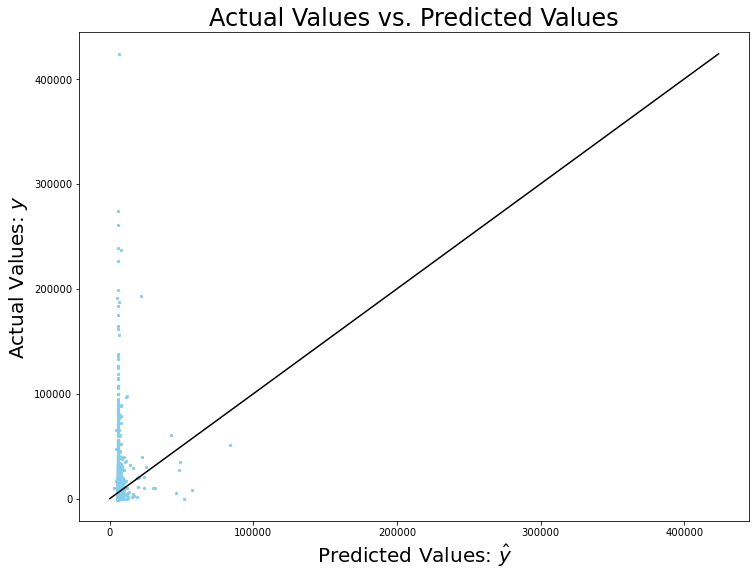

In [309]:
y_pred = lr.predict(X_test)

# Plot the model
plt.figure(figsize=(12,9))

# Generate a scatterplot of predicted values versus actual values.
plt.scatter(y_pred, y_test, s = 5, color='skyblue')

# Plot a line.
plt.plot([0, np.max(y_test)],
         [0, np.max(y_test)],
         color = 'black')

# Tweak title and axis labels.
plt.xlabel("Predicted Values: $\hat{y}$", fontsize = 20)
plt.ylabel("Actual Values: $y$", fontsize = 20)
plt.title('Actual Values vs. Predicted Values', fontsize = 24);

We can tell that there are certainly odd observations where the predictions and the target values are way off. This may be due to non linearity between the the features and labels.

### Random Forest Regressor

A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

In [313]:
# create and fit Linear Regression Model
rfr = RandomForestRegressor(n_estimators=200, random_state=25)
rfr.fit(X_train, y_train)

# RMSE for test set
rfr_testing_rmse = np.round(np.sqrt(mean_squared_error(rfr.predict(X_test), y_test)), 2)
print('Test RMSE: ' + str(rfr_testing_rmse))

Test RMSE: 202.91


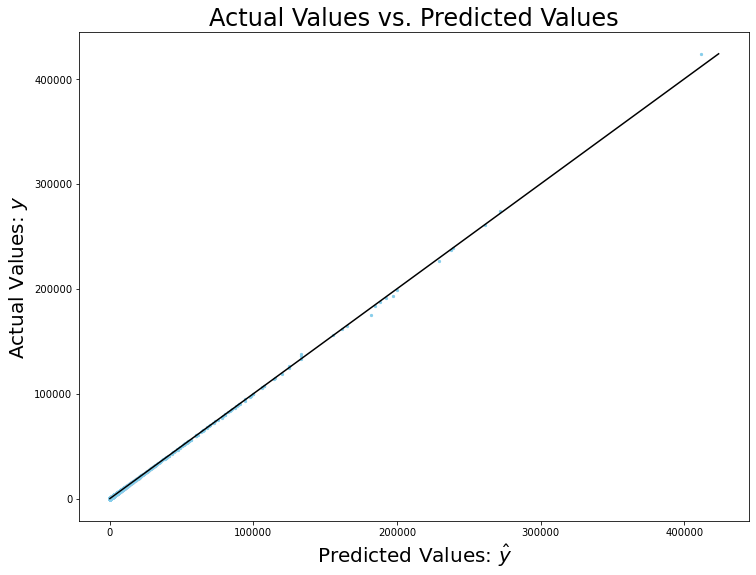

In [314]:
y_hat = rfr.predict(X_test)

# Plot the model
plt.figure(figsize=(12,9))

# Generate a scatterplot of predicted values versus actual values.
plt.scatter(y_hat, y_test, s = 5, color='skyblue')

# Plot a line.
plt.plot([0, np.max(y_test)],
         [0, np.max(y_test)],
         color = 'black')

# Tweak title and axis labels.
plt.xlabel("Predicted Values: $\hat{y}$", fontsize = 20)
plt.ylabel("Actual Values: $y$", fontsize = 20)
plt.title('Actual Values vs. Predicted Values', fontsize = 24);

Most of the blue dots fall near the black diagonal line, indicating a good fit. We will use random forest regressor to predict how much a client may be able to pay in any given period.

In [321]:
results2 = pd.DataFrame({'amount_pred_pay': np.round(y_hat.tolist(),2), 'actual_y': y_test})
results2

amount_pred_pay  actual_y
ID                              
24156             0.00       0.0
23588           300.00     300.0
3645           1750.00    1750.0
9885           1622.82    1624.0
18818        107235.76  107000.0
...                ...       ...
6360           1761.92    1762.0
12835             0.00       0.0
22647          1370.44    1371.0
3031           3871.28    3872.0
10594          1228.82    1229.0

[6000 rows x 2 columns]

### Predictions

In [368]:
# previous classifier results
results = results.sort_values(by=['ID'])

In [362]:
res = poly_df[poly_df.index.isin(list(results.ID.values))][['PAY_AMT2 PAY_AMT3', 'PAY_AMT3 PAY_AMT4', 'PAY_AMT3 PAY_AMT4 PAY_AMT6', 
             'PAY_AMT3 PAY_AMT4 PAY_AMT6^2', 'PAY_AMT1']]

In [370]:
results['pred_pay_amt'] = rfr.predict(res)

In [371]:
results

ID  default_risk  pred  pred_pay_amt
4790      4      0.390140     0      2000.000
997      13      0.202865     0      1000.000
3416     16      0.530731     1         0.000
3970     19      0.556324     1         0.000
2470     25      0.275057     0      5756.390
...     ...           ...   ...           ...
4619  29976      0.242903     0      8839.260
3276  29978      0.225376     0      7000.000
4268  29987      0.404010     0         0.000
4697  29997      0.287448     0      1837.015
316   29998      0.799341     1         0.000

[6000 rows x 4 columns]

In [372]:
results.to_csv('./datasets/results_final.csv', index=False)

## Conclusions

XGBoost proved to be the best classification model to separate defaulters and non defaulters. It attained the highest ROC AUC score of 77% in separating the classes. Some of the top important features in determining if a client would default or not are the repayment statuses and the credit card limit.

Random forest regressor is the best model to predict how much a client can pay, with the lowest root mean squared error of 203.
The predictions and actual y values are close to one another, indicating a good prediction.

For classification problem, we could further tune hyperparameters of the different models and try out more models as well. We can also drop some features that are not important in predictions.

For regression prediction, we could try more transformation of features, i.e. taking the log or exponent of features as inputs.
We could also try other non-linear regression models (i.e. XGBoostRegressor).

A limitation of Random Forest regressor is that it cannot be extrapolated, unlike linear regression. Hence, the predicted instalment paid will not exceed the highest actual instalment paid in September 2005.

As the models performed relatively well on unseen data, banks can start to predict monthly if a client will default and serve their clients better to reduce their chances of defaulting.